In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil import parser as ps

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

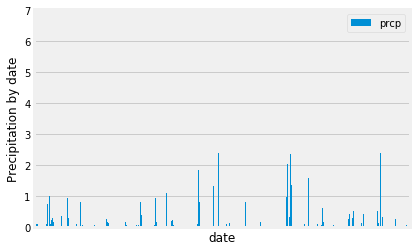

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#retrieve last date and convert to datetime
lastdate = ps.parse(engine.execute('Select max(date) from measurement').fetchall()[0][0])
#calculate date 1 year prior
oneyear = dt.timedelta(days=365)
prvdate = lastdate - oneyear
#convert dates back to strings
lastdatestr = lastdate.strftime('%Y-%m-%d')
prvdatestr = prvdate.strftime('%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
lastyr =  session.query(Measurement.station, Measurement.date, 
                        Measurement.prcp, Measurement.tobs).filter(Measurement.date.between(prvdatestr, lastdatestr)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measure_df = pd.DataFrame(lastyr, columns = ['station', 'date', 'prcp', 'tobs'])
measure_df.set_index('date', inplace = False)
# Sort the dataframe by date
measured_df = measure_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
measured_df.plot.bar('date', 'prcp', stacked = True)
plt.xticks([])
plt.ylabel("Precipitation by date")
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measured_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = engine.execute('Select count(station) from station').fetchall()[0][0]
print(stations)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature at the most active station?
top_s = activity[0][0]
top_temp = session.query(Measurement.tobs, func.max(Measurement.tobs)).filter(Measurement.station == top_s).all()
top_low = session.query(Measurement.tobs, func.min(Measurement.tobs)).filter(Measurement.station == top_s).all()
top_avg = session.query(Measurement.tobs, func.avg(Measurement.tobs)).filter(Measurement.station == top_s).all()
print(f"Highest temp {top_temp[0][0]}")
print(f"Lowest temp {top_low[0][0]}")
print(f"Average temp {top_avg[0][1]}")

Highest temp 85.0
Lowest temp 54.0
Average temp 71.66378066378067


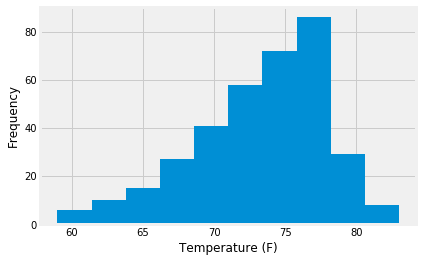

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_df = measured_df['tobs'].loc[measured_df['station'] == top_s]
station_df.plot.hist(by='tobs')
plt.xlabel("Temperature (F)")
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2011-02-28'
enddate = '2011-03-05'
prev_temps = calc_temps(startdate, enddate)[0]
print(prev_temps)

(61.0, 69.75510204081633, 75.0)


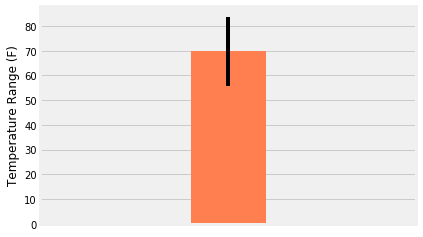

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
prev_min = prev_temps[0]
prev_avg = prev_temps[1]
prev_max = prev_temps[2]
plt.bar(0, prev_avg, width = .4, yerr = prev_max - prev_min, color = 'coral')
plt.xlim(-1,1)
plt.xticks([])
plt.ylabel("Temperature Range (F)")
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainagg = session.query(Measurement.station,func.sum(Measurement.prcp), Station.name, Station.latitude, 
                        Station.longitude, Station.elevation).filter(Measurement.date.between(startdate, enddate)).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).\
join(Station, Station.station == Measurement.station).all()

for item in rainagg:
    print(item)

('USC00518838', 2.33, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
('USC00519281', 2.23, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00519523', 2.19, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 1.96, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00516128', 1.45, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00513117', 1.44, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519397', 1.38, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00511918', 0.63, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
